In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/CT_Scans'

Mounted at /content/drive
/content/drive/MyDrive/CT_Scans


In [ ]:
#Importing all the required libraries
from __future__ import print_function, division
from builtins import range, input
from tensorflow.keras.layers import Input, Lambda, Flatten, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [ ]:
#Changing the image size
IMAGE_SIZE = [224, 224] 
#Setting the number of epochs
epochs = 500
#Setting batch size of images
batch_size = 32
#Setting path
covid_ct_path = 'CT_COVID'
noncovid_ct_path = 'CT_NonCOVID'
covid_ct_files = glob(covid_ct_path + '/*')
noncovid_ct_files = glob(noncovid_ct_path + '/*')

In [ ]:
covid_ct_labels = []
noncovid_ct_labels = []
covid_ct_images=[]
noncovid_ct_images=[]
import cv2 

for i in range(len(covid_ct_files)):
  image = cv2.imread(covid_ct_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_ct_images.append(image)
  covid_ct_labels.append('CT_Scan_COVID')
for i in range(len(noncovid_ct_files)):
  image = cv2.imread(noncovid_ct_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_ct_images.append(image)
  noncovid_ct_labels.append('CT_Scan_NonCOVID')

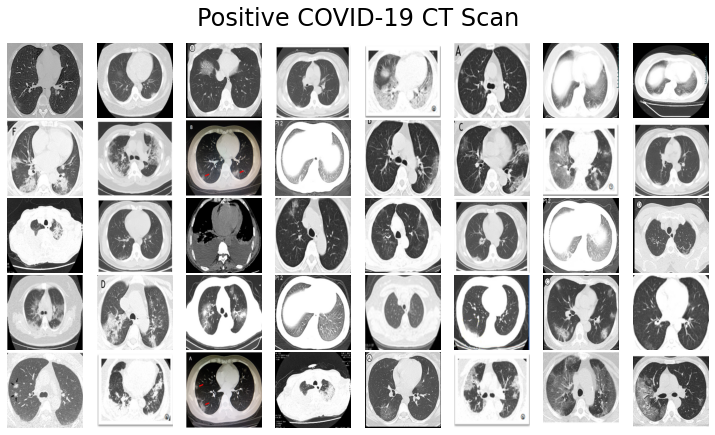

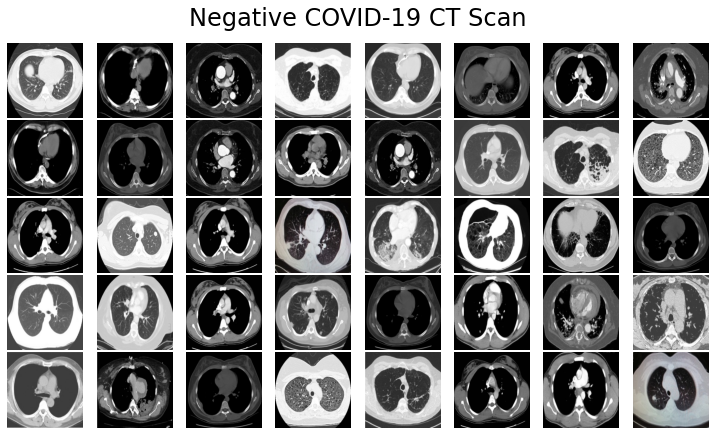

In [ ]:
def image_plot(images, title):
    figsize = [10, 6]
    fig, ax = plt.subplots(nrows=5, ncols=8, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
    
image_plot(covid_ct_images, 'Positive COVID-19 CT Scan')
image_plot(noncovid_ct_images, 'Negative COVID-19 CT Scan')

Normalization

In [ ]:
# normalize to interval of [0,1]
covid_ct_images = np.array(covid_ct_images) / 255
noncovid_ct_images = np.array(noncovid_ct_images) / 255

Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# Splitting into 80% and 20% train and test.
covid_ct_x_train, covid_ct_x_test, covid_ct_y_train, covid_ct_y_test = train_test_split(
    covid_ct_images, covid_ct_labels, test_size=0.2)
noncovid_ct_x_train, noncovid_ct_x_test, noncovid_ct_y_train, noncovid_ct_y_test = train_test_split(
    noncovid_ct_images, noncovid_ct_labels, test_size=0.2)


X_train = np.concatenate((noncovid_ct_x_train, covid_ct_x_train), axis=0)
X_test = np.concatenate((noncovid_ct_x_test, covid_ct_x_test), axis=0)
y_train = np.concatenate((noncovid_ct_y_train, covid_ct_y_train), axis=0)
y_test = np.concatenate((noncovid_ct_y_test, covid_ct_y_test), axis=0)

# Categorizing into 1 or 0
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

Visualize a few images from Training and Test sets

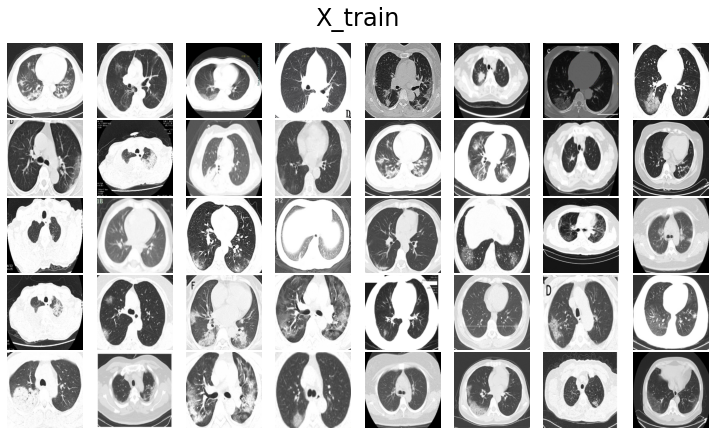

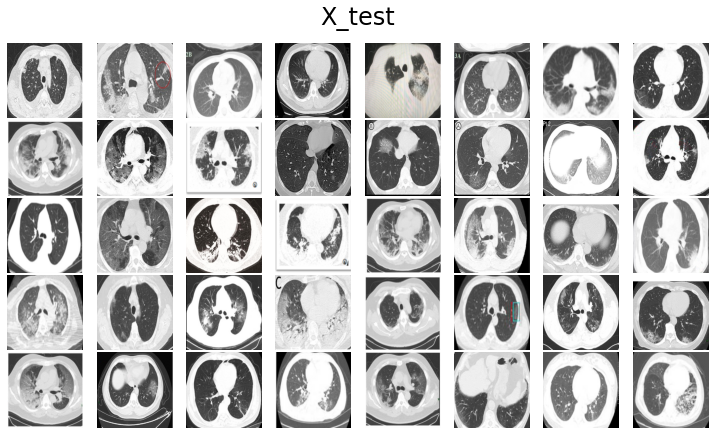

In [ ]:
image_plot(covid_ct_x_train, 'X_train')
image_plot(covid_ct_x_test, 'X_test')

Building and Visualizing model

In [ ]:
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
18/18 [==============================] - 19s 526ms/step - loss: 2.7163 - accuracy: 0.6023 - val_loss: 1.9859 - val_accuracy: 0.6533
Epoch 2/500
18/18 [==============================] - 8s 412ms/step - loss: 2.1321 - accuracy: 0.6846 - val_loss: 1.2930 - val_accuracy: 0.7333
Epoch 3/500
18/18 [==============================] - 8s 422ms/step - loss: 1.3997 - accuracy: 0.7399 - val_loss: 1.1410 - val_accuracy: 0.7133
Epoch 4/500
18/18 [==============================] - 8s 414ms/step - loss: 1.0289 - accuracy: 0.7584 - val_loss: 0.8994 - val_accuracy: 0.7733
Epoch 5/500
18/18 [==============================] - 8s 404ms/step - loss: 1.2497 - accuracy: 0.7466 - val_loss: 1.2336 - val_accuracy: 0.7400
Epoch 6/500
18/18 [==============================] - 8s 418ms/step - loss: 1.2600 - accuracy: 0.7668 - val_loss: 2.6794 - val_accuracy: 0.6600
Epoch 7/500
18/18 [==============================] - 8s 405ms/step - loss: 1.2355 - accuracy: 0.7651 - val_loss: 1.1670 - val_accuracy: 0.760

Making Predicions

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

5/5 [==============================] - 1s 139ms/step


Visulaizing First 10 predictions

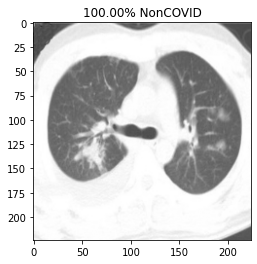

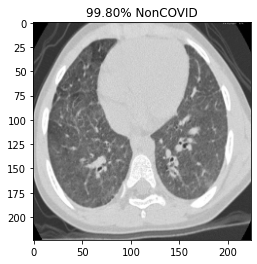

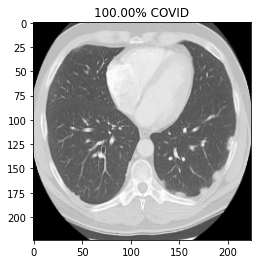

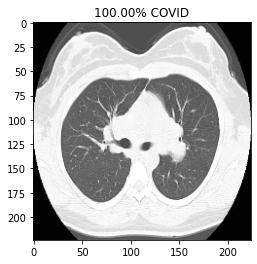

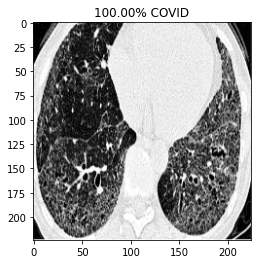

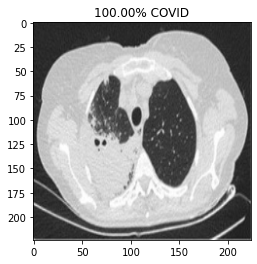

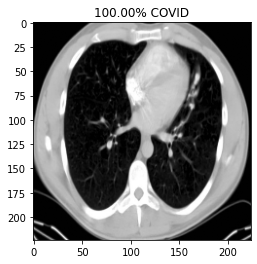

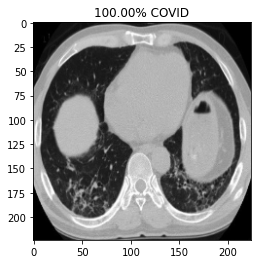

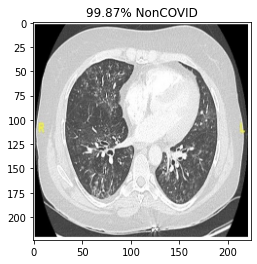

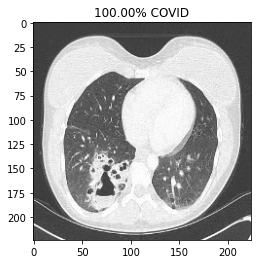

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

Plot ROC Curve

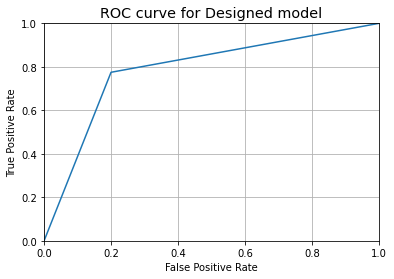

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 14
plt.title('The ROC curve for the model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Plot Confusion Matrix

Confusion Matrix without Normalization


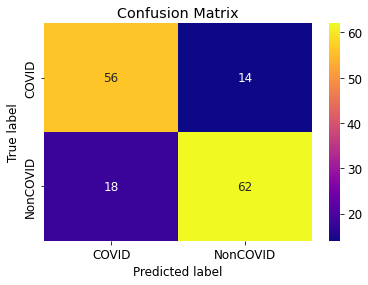

Confusion Matrix with Normalized Values


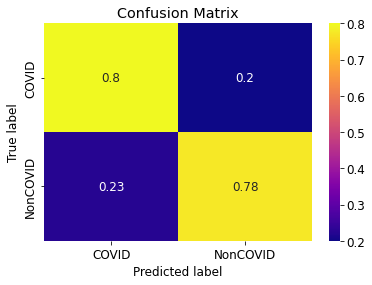

In [ ]:
def plotting_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plotting_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plotting_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        70
           1       0.82      0.78      0.79        80

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150



Accuracy and Loss Plots

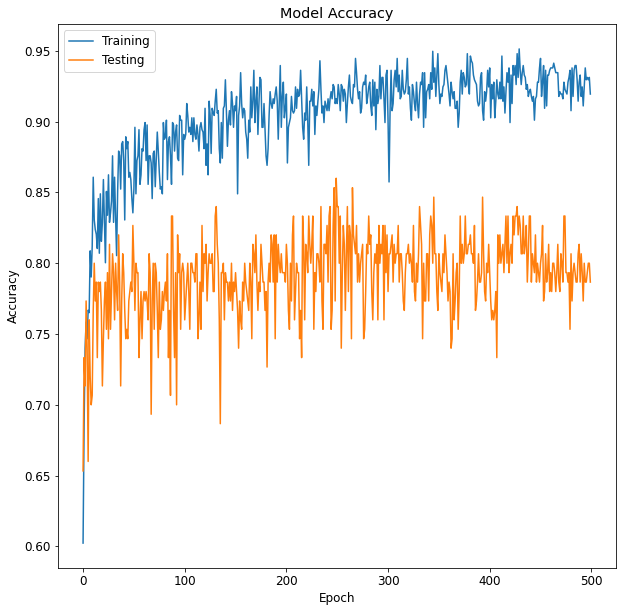

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_ct_accuracy.png')
plt.show()

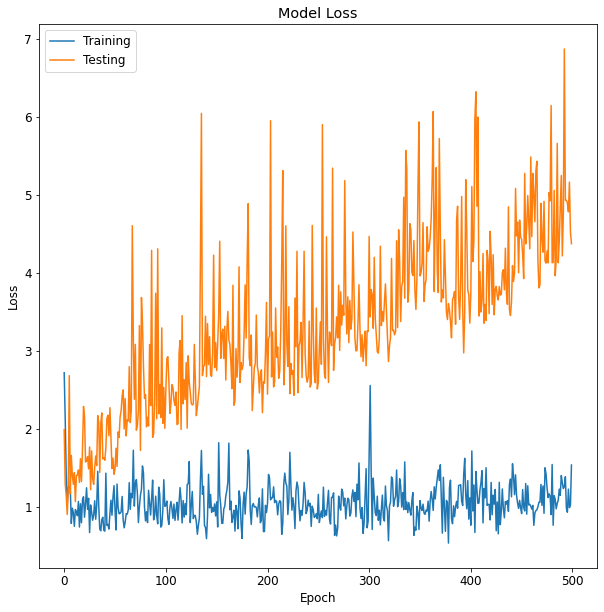

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_ct_loss.png')
plt.show()

References - 


*   https://medium.com/mlearning-ai/dive-into-medical-imaging-image-augmentation-approach-4cfad0f306e3
*   https://pyimagesearch.com/2020/07/06/region-proposal-object-detection-with-opencv-keras-and-tensorflow/

*   https://github.com/iRaph01/COVID-CT-Project